In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re
import nltk

import torch                                                      
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification, AdamW,BertTokenizer,get_linear_schedule_with_warmup

import time
import datetime

In [3]:
nltk.download("popular")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\Ernest\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\Ernest\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\Ernest\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\Ernest\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\Ernest\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_dat

device(type='cpu')

In [4]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

In [28]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [14]:
train_df['text_length'] = train_df['text'].apply(len)

In [15]:
train_df.describe()

,id,target,text_length
count,7613.000000,7613.00000,7613.000000
mean,5441.934848,0.42966,101.037436
std,3137.116090,0.49506,33.781325
min,1.000000,0.00000,7.000000
25%,2734.000000,0.00000,78.000000
50%,5408.000000,0.00000,107.000000
75%,8146.000000,1.00000,133.000000
max,10873.000000,1.00000,157.000000


In [16]:
all_words = [word for tweet in train_df["text"] for word in tweet.split(" ")]
vocab = Counter(all_words)

In [17]:
print("Least Common")
print(vocab.most_common()[-10:])
print("Most Common")
print(vocab.most_common(n=10))

Least Common
[('#LA', 1), ('http://t.co/5ueCmcv2Pk', 1), ('Forney', 1), ('developing', 1), ('symptoms...', 1), ('http://t.co/rqKK15uhEY', 1), ('flip', 1), ('http://t.co/nF4IculOje', 1), ('http://t.co/STfMbbZFB5', 1), ('http://t.co/YmY4rSkQ3d', 1)]
Most Common
[('the', 2573), ('a', 1840), ('to', 1804), ('in', 1757), ('of', 1721), ('and', 1301), ('I', 1186), ('for', 820), ('is', 814), ('on', 773)]


In [18]:
counts = list(vocab.values())
train_df["word_count"] = train_df["text"].apply(lambda x: len(x.split(" ")))
train_df["word_count"].describe()

count    7613.000000
mean       14.928937
std         5.782770
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        54.000000
Name: word_count, dtype: float64

In [19]:
train_df[['text_length', 'target']].groupby('target').mean()['text_length']

target
0     95.706817
1    108.113421
Name: text_length, dtype: float64

In [22]:
train_df[['text_length', 'target']].groupby('target').mean()['text_length']

target
0     95.706817
1    108.113421
Name: text_length, dtype: float64

c:\Users\Ernest\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Ernest\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Ernest\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


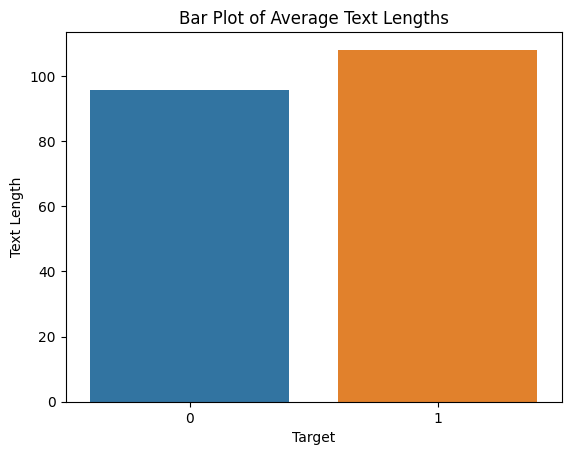

In [29]:
sns.barplot(y=train_df.groupby('target')['text_length'].mean(), x=train_df['target'].unique())
plt.xlabel('Target')
plt.ylabel('Text Length')
plt.title('Bar Plot of Average Text Lengths')
plt.show() 

c:\Users\Ernest\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Ernest\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Ernest\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


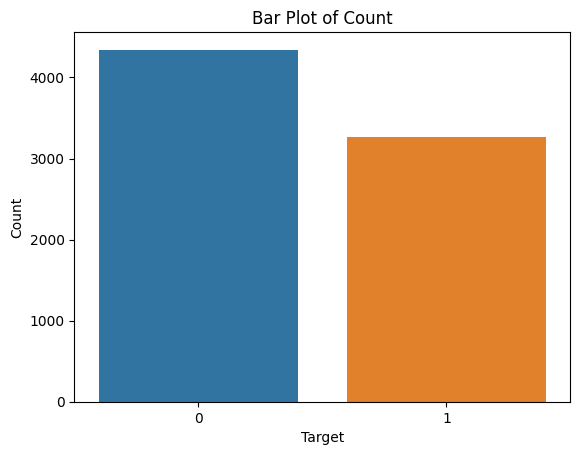

In [30]:
sns.barplot(y=train_df.groupby('target').count()['text_length'], x=train_df.groupby('target').sum().index)
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Bar Plot of Count')
plt.show()

In [31]:
train_df[train_df["target"] == 0]["text"].values[1]

'I love fruits'

In [32]:
def remove_hashtag(text):
    pattern= "#[\w\d]+"
    return re.sub(pattern, "", text)

def remove_url(text):
    pattern = r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)"
    return re.sub(pattern, "", text)
    
train_df['text_without_hastag'] = train_df['text'].apply(remove_hashtag)
train_df['text_without_url'] = train_df['text_without_hastag'].apply(remove_url)

In [33]:
pattern = r'[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'

def count_non_english(text):
    return len(re.findall(pattern, text))

train_df['non_english_count'] = train_df['text_without_url'].apply(count_non_english)

In [34]:
train_df['non_english_count'].sum()

341

In [35]:
def remove_non_english(text):
    pattern = r'[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'
    return re.sub(pattern, "", text)
train_df['text_without_funny'] = train_df['text_without_url'].apply(remove_non_english)

c:\Users\Ernest\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Ernest\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Ernest\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


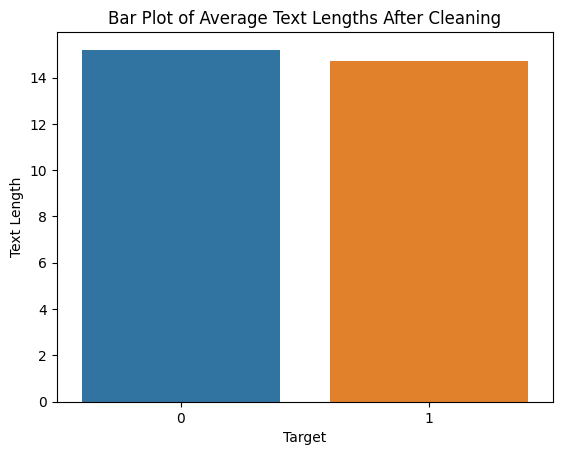

In [37]:
train_df['text_length'] = train_df['text_without_funny'].apply(lambda x: len(x.split(" ")))
sns.barplot(y=train_df.groupby('target')['text_length'].mean(), x=train_df['target'].unique())
plt.xlabel('Target')
plt.ylabel('Text Length')
plt.title('Bar Plot of Average Text Lengths After Cleaning')
plt.show() 

<Axes: >

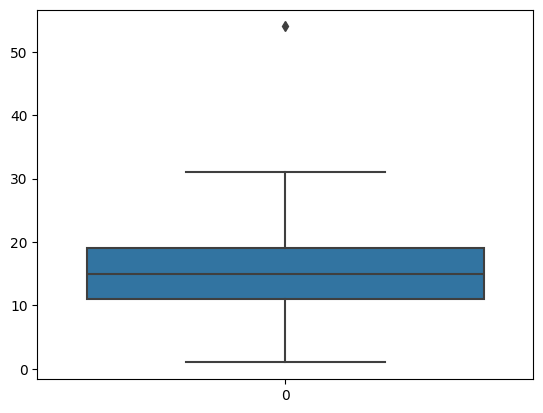

In [39]:
sns.boxplot(train_df['text_length'])

In [40]:
train_df,test_df= train_test_split(train_df[['text_without_funny', 'target']], test_size=0.2, random_state=90,shuffle=True, stratify=train_df['target'])

In [93]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [94]:
tweets = train_df['text_without_funny'].values
labels = train_df['target'].values 

In [95]:
print(' Original: ', tweets[5])
print()
# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(tweets[5]))
print()
# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tweets[5])))

 Original:  don't you dare play the victim when I've been drowning for years.

Tokenized:  ['don', "'", 't', 'you', 'dare', 'play', 'the', 'victim', 'when', 'i', "'", 've', 'been', 'drowning', 'for', 'years', '.']

Token IDs:  [2123, 1005, 1056, 2017, 8108, 2377, 1996, 6778, 2043, 1045, 1005, 2310, 2042, 14759, 2005, 2086, 1012]


In [96]:
max_len = 0
for sent in tweets:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

input_ids = []
attention_masks = []
for tweet in tweets:
    encoded_dict = tokenizer.encode_plus(
                        tweet,                      
                        add_special_tokens = True,
                        max_length = max_len,         
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('Original: ', tweets[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\Ernest\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Series finale of  :( It survived so much upheaval but the audience got so much good story.
Token IDs: tensor([  101,  2186,  9599,  1997,  1024,  1006,  2009,  5175,  2061,  2172,
         2039, 20192, 10175,  2021,  1996,  4378,  2288,  2061,  2172,  2204,
         2466,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])


In [97]:
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.8 * len(dataset))
val_size = len(dataset)  - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

4,872 training samples
1,218 validation samples


In [98]:
batch_size = 32

train_dataloader = DataLoader(
            train_dataset, 
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

In [99]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2, 
    output_attentions = False,
    output_hidden_states = False
)
model = model.to(device)
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Ernest\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [100]:
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [101]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [102]:
training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = output.loss
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    print("")
    print("Running Validation...")
    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    best_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():
            output= model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    if avg_val_accuracy > best_eval_accuracy:
        torch.save(model, 'bert_model')
        best_eval_accuracy = avg_val_accuracy
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...

  Average training loss: 0.46
  Training epcoh took: 0:29:18

Running Validation...
  Accuracy: 0.81

======== Epoch 2 / 5 ========
Training...

  Average training loss: 0.34
  Training epcoh took: 0:24:56

Running Validation...
  Accuracy: 0.80

======== Epoch 3 / 5 ========
Training...

  Average training loss: 0.27
  Training epcoh took: 0:24:09

Running Validation...
  Accuracy: 0.83

======== Epoch 4 / 5 ========
Training...

  Average training loss: 0.21
  Training epcoh took: 0:22:53

Running Validation...
  Accuracy: 0.83

======== Epoch 5 / 5 ========
Training...

  Average training loss: 0.17
  Training epcoh took: 0:23:10

Running Validation...
  Accuracy: 0.82

Training complete!
Total training took 2:14:55 (h:mm:ss)
